In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATA_PROCESSED_DIR = os.path.join(PROJECT_ROOT, 'data','processed')


path=os.path.join(DATA_PROCESSED_DIR, 'aqi_processed_data.csv')
df=pd.read_csv(path)

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df=df.sort_values(['City','Timestamp']).reset_index(drop=True)

print(df.shape)
df.head()

(5481, 18)


,Timestamp,City,PM2.5,PM10,NO2,NH3,CO,SO2,O3,PM2.5_was_missing,PM10_was_missing,NO2_was_missing,NH3_was_missing,CO_was_missing,SO2_was_missing,O3_was_missing,AQI,n_avail_sub
0,2020-01-01,Bengaluru,43.67,134.00,20.28,10.98,0.91,3.41,21.82,1,1,1,1,1,1,1,122.926174,7
1,2020-01-02,Bengaluru,43.67,134.00,20.28,10.98,0.91,3.41,21.82,0,0,0,0,0,0,0,122.926174,7
2,2020-01-03,Bengaluru,30.58,74.42,15.17,12.10,0.96,3.27,23.31,0,0,0,0,0,0,0,74.420000,6
3,2020-01-04,Bengaluru,66.35,155.68,42.90,11.75,2.54,3.26,29.70,0,0,0,0,0,0,0,137.331007,7
4,2020-01-05,Bengaluru,48.00,99.13,18.56,9.79,1.14,2.95,31.01,0,0,0,0,0,0,0,99.130000,7


In [3]:
#MAE function

def mae(y_true, y_pred):
    y_true=np.asarray(y_true)
    y_pred=np.asarray(y_pred)
    return np.mean(np.abs(y_true - y_pred))

# RMSE function

def rmse(y_true,y_pred):
    y_true=np.asarray(y_true)
    y_pred=np.asarray(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))

#sMAPE function

def smape(y_true,y_pred,eps=1e-8):
    y_true=np.asarray(y_true)
    y_pred=np.asarray(y_pred)
    denom=(np.abs(y_true) + np.abs(y_pred) + eps)/2.0
    return np.mean(np.abs(y_true-y_pred)/denom) * 100

In [4]:
TRAIN_END=pd.Timestamp("2023-12-31")
VAL_END=pd.Timestamp("2024-06-30")


def add_split_flag(city_df:pd.DataFrame)->pd.DataFrame:
    city_df=city_df.sort_values('Timestamp').copy()
    city_df['split']='test'
    city_df.loc[city_df['Timestamp'] <= VAL_END, 'split'] = 'val'
    city_df.loc[city_df['Timestamp'] <= TRAIN_END, 'split'] = 'train'
    return city_df

df=df.groupby('City', group_keys=False).apply(add_split_flag)
print(df['split'].value_counts())

split
train    4383
test      552
val       546
Name: count, dtype: int64


C:\Users\vichu\AppData\Local\Temp\ipykernel_12320\1367863302.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df=df.groupby('City', group_keys=False).apply(add_split_flag)


In [5]:
HORIZON = 1
SEASONAL_LAG=7

def add_baseline_forecast(city_df:pd.DataFrame)->pd.DataFrame:
    city_df=city_df.sort_values('Timestamp').copy()

    #next day AQI
    city_df['y_true']=city_df['AQI'].shift(-HORIZON)

    #Naive:yesterday's AQI predicts tomorrows AQI
    city_df['y_pred_naive']=city_df['AQI']

    #Seasonal Naive: AQI from last week predicts tomorrows AQI
    city_df['y_pred_snaive']=city_df['AQI'].shift(SEASONAL_LAG)

    return city_df

df=df.groupby('City', group_keys=False).apply(add_baseline_forecast)
df.head(10)

C:\Users\vichu\AppData\Local\Temp\ipykernel_12320\3463885244.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df=df.groupby('City', group_keys=False).apply(add_baseline_forecast)


,Timestamp,City,PM2.5,PM10,NO2,NH3,CO,SO2,O3,PM2.5_was_missing,...,NH3_was_missing,CO_was_missing,SO2_was_missing,O3_was_missing,AQI,n_avail_sub,split,y_true,y_pred_naive,y_pred_snaive
0,2020-01-01,Bengaluru,43.67,134.00,20.28,10.98,0.91,3.41,21.82,1,...,1,1,1,1,122.926174,7,train,122.926174,122.926174,NaN
1,2020-01-02,Bengaluru,43.67,134.00,20.28,10.98,0.91,3.41,21.82,0,...,0,0,0,0,122.926174,7,train,74.420000,122.926174,NaN
2,2020-01-03,Bengaluru,30.58,74.42,15.17,12.10,0.96,3.27,23.31,0,...,0,0,0,0,74.420000,6,train,137.331007,74.420000,NaN
3,2020-01-04,Bengaluru,66.35,155.68,42.90,11.75,2.54,3.26,29.70,0,...,0,0,0,0,137.331007,7,train,99.130000,137.331007,NaN
4,2020-01-05,Bengaluru,48.00,99.13,18.56,9.79,1.14,2.95,31.01,0,...,0,0,0,0,99.130000,7,train,63.340000,99.130000,NaN
5,2020-01-06,Bengaluru,23.75,63.34,17.21,7.40,1.08,2.82,25.82,0,...,0,0,0,0,63.340000,6,train,72.000000,63.340000,NaN
6,2020-01-07,Bengaluru,24.67,72.00,17.20,7.66,0.98,2.97,30.37,0,...,0,0,0,0,72.000000,7,train,79.060000,72.000000,NaN
7,2020-01-08,Bengaluru,34.18,79.06,18.16,9.35,0.99,2.99,29.61,0,...,0,0,0,0,79.060000,7,train,98.000000,79.060000,122.926174
8,2020-01-09,Bengaluru,41.61,98.00,21.49,11.21,1.11,2.98,30.97,0,...,0,0,0,0,98.000000,7,train,97.700000,98.000000,122.926174
9,2020-01-10,Bengaluru,38.95,97.70,19.77,12.80,0.97,3.34,31.89,0,...,0,0,0,0,97.700000,7,train,77.560000,97.700000,74.420000


In [6]:
def evaluate_split(city_df:pd.DataFrame,split_name:str):
    tmp=city_df[city_df['split']==split_name].copy()

    #Remove rows with NaN in y_true or y_pred columns
    tmp=tmp.dropna(subset=['y_true','y_pred_naive','y_pred_snaive'])

    out={
        'City':tmp['City'].iloc[0],
        'split':split_name,
        'Naive_MAE':mae(tmp['y_true'], tmp['y_pred_naive']),
        'Naive_RMSE':rmse(tmp['y_true'], tmp['y_pred_naive']),
        'Naive_sMAPE':smape(tmp['y_true'], tmp['y_pred_naive']),
        'SNaive_MAE':mae(tmp['y_true'], tmp['y_pred_snaive']),
        'SNaive_RMSE':rmse(tmp['y_true'], tmp['y_pred_snaive']),
        'SNaive_sMAPE':smape(tmp['y_true'], tmp['y_pred_snaive']),
        'n':len(tmp)
    }
    return out

rows=[]
for city,g in df.groupby('City'):
    rows.append(evaluate_split(g,'val'))
    rows.append(evaluate_split(g,'test'))

baseline_results=pd.DataFrame(rows)
baseline_results

,City,split,Naive_MAE,Naive_RMSE,Naive_sMAPE,SNaive_MAE,SNaive_RMSE,SNaive_sMAPE,n
0,Bengaluru,val,28.220471,66.406153,24.086772,42.612518,81.565258,36.012057,182
1,Bengaluru,test,23.471867,30.791394,28.427919,38.006846,48.839397,43.872505,183
2,Delhi,val,46.211178,63.142464,21.889198,69.489316,90.438174,31.214213,182
3,Delhi,test,29.662738,41.429295,17.235311,58.444041,79.493961,29.285043,183
4,Mumbai,val,12.045688,17.111079,13.651348,23.594518,30.684020,25.973733,182
5,Mumbai,test,11.177839,16.185338,15.703983,23.189387,30.274457,33.119412,183


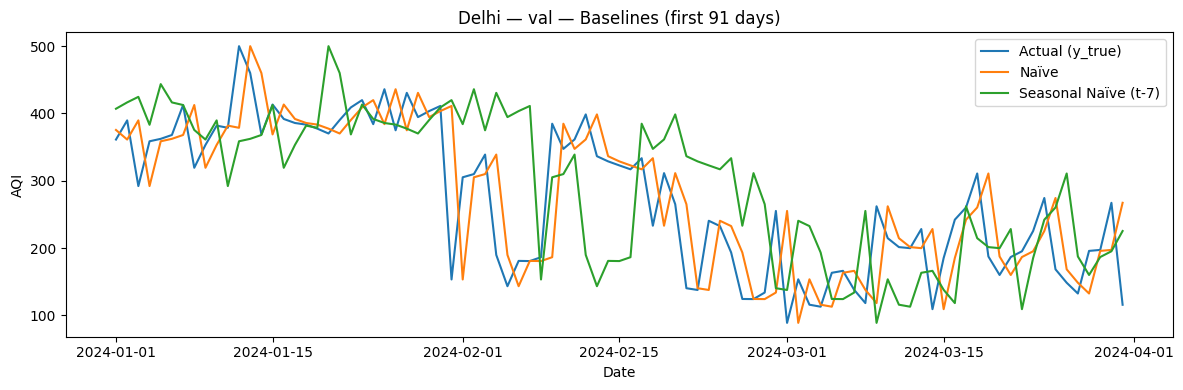

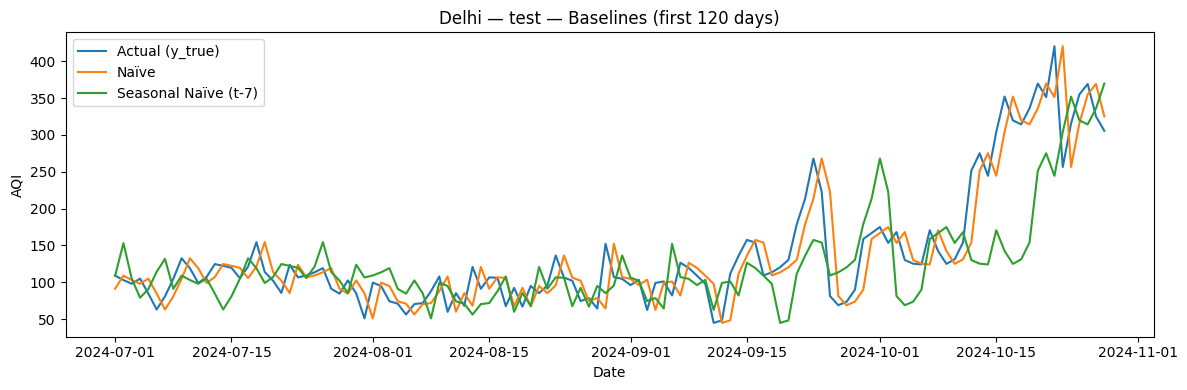

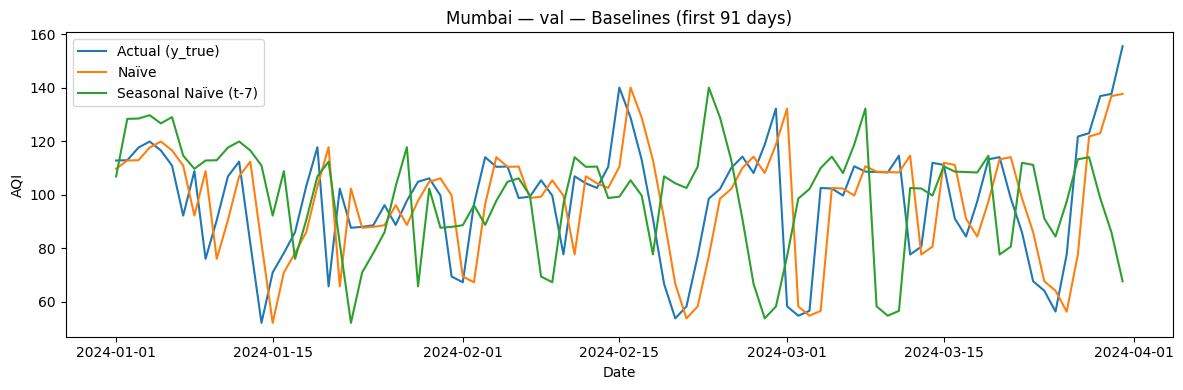

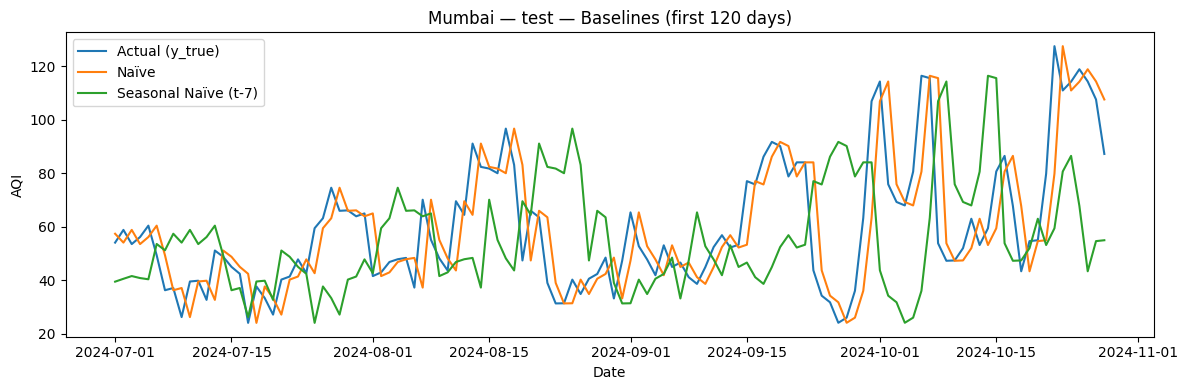

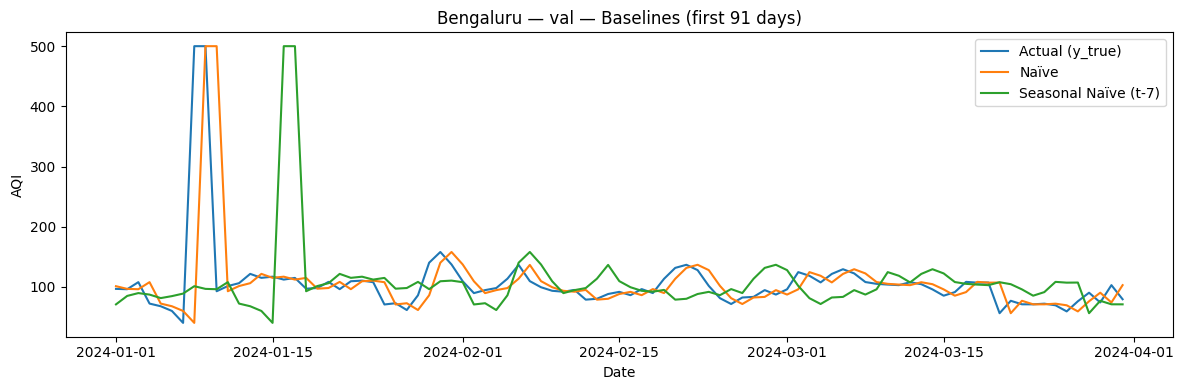

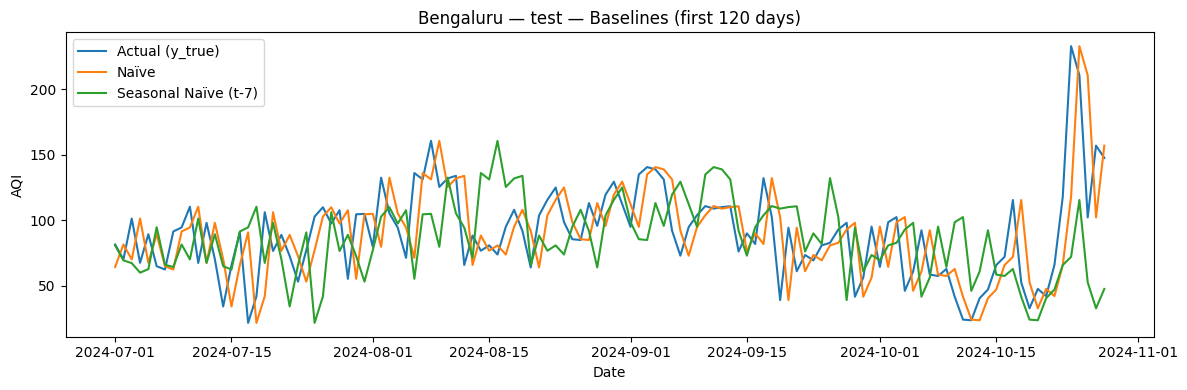

In [7]:
def plot_baseline(city:str,split_name:str,n_days:int=120):
    tmp = df[(df["City"] == city) & (df["split"] == split_name)].copy()
    tmp = tmp.dropna(subset=["y_true", "y_pred_naive", "y_pred_snaive"]).head(n_days)

    plt.figure(figsize=(12, 4))
    plt.plot(tmp["Timestamp"],tmp["y_true"],label="Actual (y_true)")
    plt.plot(tmp["Timestamp"],tmp["y_pred_naive"],label="Naïve")
    plt.plot(tmp["Timestamp"],tmp["y_pred_snaive"],label="Seasonal Naïve (t-7)")
    plt.title(f"{city} — {split_name} — Baselines (first {n_days} days)")
    plt.xlabel("Date")
    plt.ylabel("AQI")
    plt.legend()
    plt.tight_layout()
    plt.show()

for city in ['Delhi','Mumbai','Bengaluru']:
    plot_baseline(city,'val',n_days=91)
    plot_baseline(city,'test',n_days=120)

In [8]:
OUTPUTS_DIR = os.path.join(PROJECT_ROOT, 'outputs')
os.makedirs(OUTPUTS_DIR, exist_ok=True)

baseline_results.to_csv(os.path.join(OUTPUTS_DIR, 'baseline_results.csv'), index=False)
print('Saved outputs/baseline_results.csv')

Saved outputs/baseline_results.csv
